In [1]:
import multimodal_cci as mmcci
import scanpy as sc
import numpy as np
from matplotlib import pyplot as plt

#### Load stLearn data objects

In [2]:
visium = [
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/vis1_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/vis2_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/vis3_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/vis4_cci.h5ad")
]

xenium = [
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/xenium1_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/xenium2_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/xenium3_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/xenium4_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/xenium5_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/xenium6_cci.h5ad")
]

cosmx = [
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx0_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx1_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx2_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx3_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx4_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx5_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx6_cci.h5ad"),
    sc.read_h5ad("/scratch/user/uqlhocke/mmcci_melanoma/cosmx7_cci.h5ad")
]

visium_cci = [sample.uns['per_lr_cci_cell_type'] for sample in visium]
xenium_cci = [sample.uns['per_lr_cci_cell_type'] for sample in xenium]
cosmx_cci = [sample.uns['per_lr_cci_cell_type'] for sample in cosmx]

visium_sizes = [sample.shape[0] for sample in visium]
xenium_sizes = [sample.shape[0] for sample in xenium]
cosmx_sizes = [sample.shape[0] for sample in cosmx]

In [3]:
colors = {
    'Endothelial': plt.colormaps.get_cmap('tab20').colors[0],
    'Fibroblast': plt.colormaps.get_cmap('tab20').colors[1],
    'KC Differentiating': plt.colormaps.get_cmap('tab20').colors[2],
    'KC Cycling': plt.colormaps.get_cmap('tab20').colors[3],
    'KC Basal': plt.colormaps.get_cmap('tab20').colors[4],
    'KC Other': plt.colormaps.get_cmap('tab20').colors[5],
    'NK + T': plt.colormaps.get_cmap('tab20').colors[6],
    'B + PDC': plt.colormaps.get_cmap('tab20').colors[7],
    'Melanocyte': plt.colormaps.get_cmap('tab20').colors[8],
    'Myeloid': plt.colormaps.get_cmap('tab20').colors[9],
    'Pilosebaceous': plt.colormaps.get_cmap('tab20').colors[10]
}

In [4]:
cell_type_replacements = {
    'KC.Basal': 'KC Basal',
    'KC_Basal': 'KC Basal',
    'KC.Cycling': 'KC Cycling',
    'KC_Cyc': 'KC Cycling',
    'KC_Diff': 'KC Differentiating',
    'KC_Other': 'KC Other',
    'NK.T': 'NK + T',
    'B.PDC': 'B + PDC',
    'B...PDC': 'B + PDC',
}
for i in range(len(visium_cci)):
    for lr_pair in visium_cci[i].keys():
        visium_cci[i][lr_pair].rename(
            index=cell_type_replacements,
            columns=cell_type_replacements,
            inplace=True)

for i in range(len(xenium_cci)):
    for lr_pair in xenium_cci[i].keys():
        xenium_cci[i][lr_pair].rename(
            index=cell_type_replacements,
            columns=cell_type_replacements,
            inplace=True)

for i in range(len(cosmx_cci)):
    for lr_pair in cosmx_cci[i].keys():
        cosmx_cci[i][lr_pair].rename(
            index=cell_type_replacements,
            columns=cell_type_replacements,
            inplace=True)

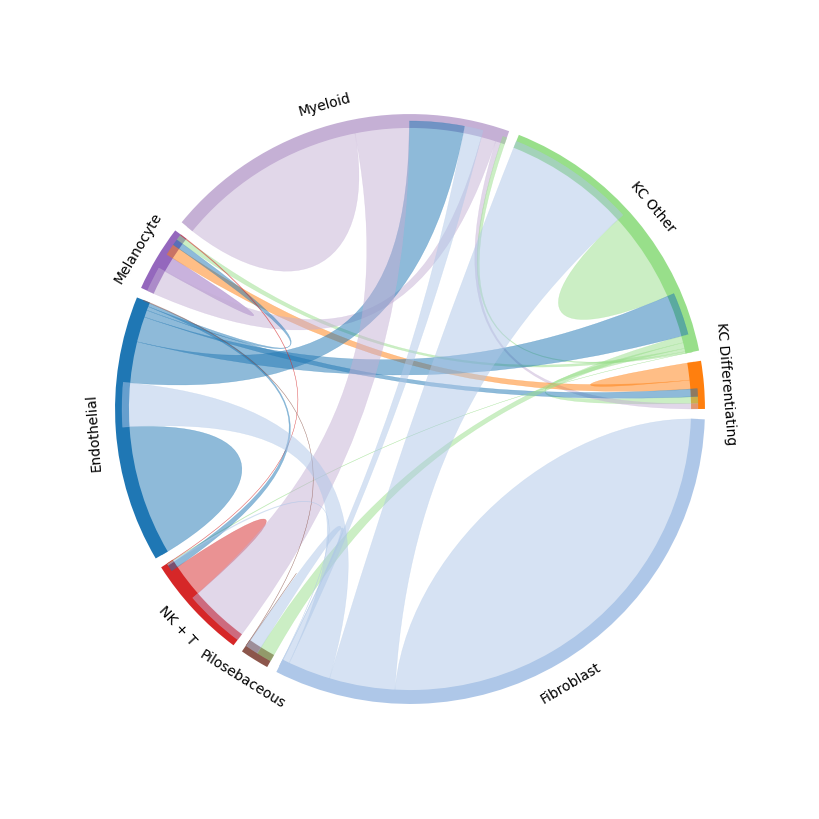

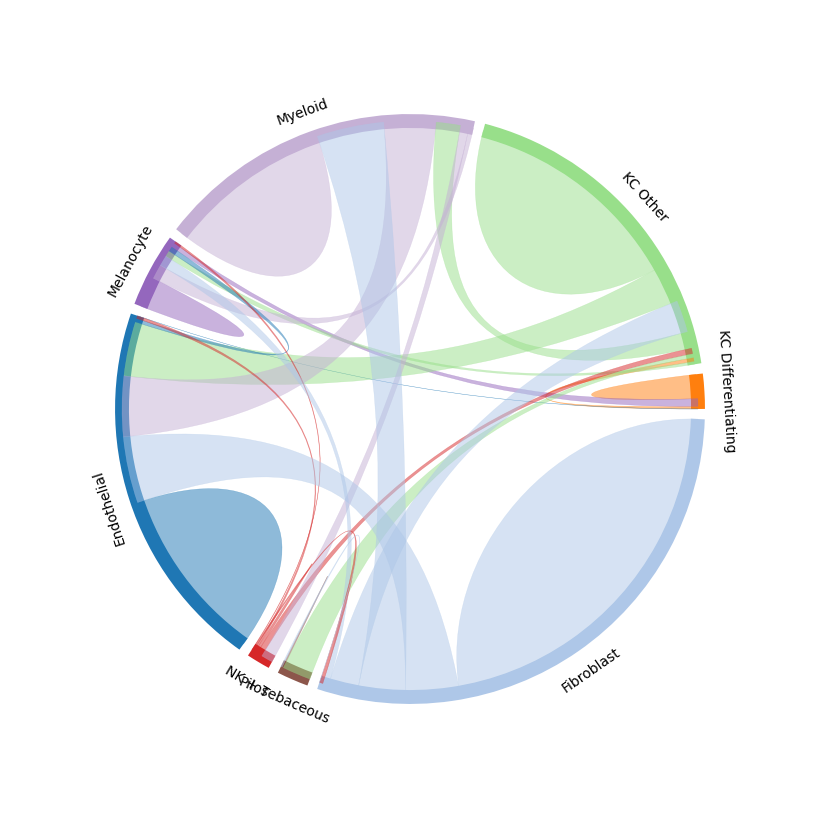

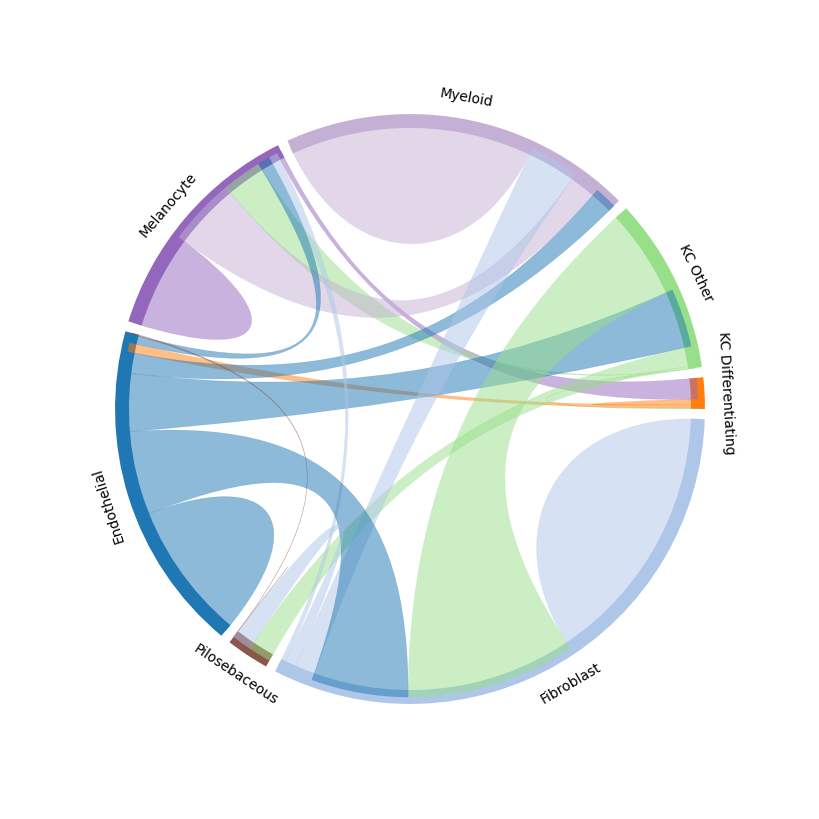

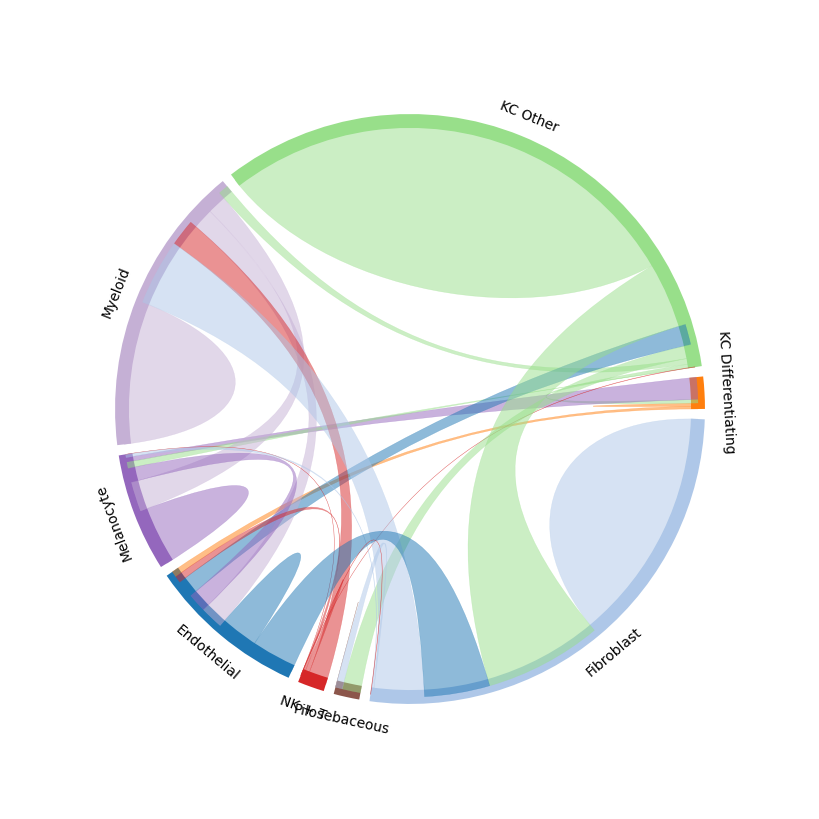

In [5]:
for sample in visium_cci:
    overall = mmcci.it.calculate_overall_interactions(sample)
    mmcci.plt.chord_plot(overall, colors=colors)

#### Normalise each group of samples

In [6]:
visium_normalised = mmcci.it.normalise_samples_to_target(
    visium_cci, visium_sizes, target=visium_sizes[0])
xenium_normalised = mmcci.it.normalise_samples_to_target(
    xenium_cci, xenium_sizes, target=xenium_sizes[0])
cosmx_normalised = mmcci.it.normalise_samples_to_target(
    cosmx_cci, cosmx_sizes, target=cosmx_sizes[0])

#### Integrate Patients

- 6747: vis4, cosmx1
- 21031: vis2, cosmx2, cosmx3
- 48974: vis1, cosmx4, cosmx5, cosmx6
- 66487: vis3, cosmx7, cosmx8



In [7]:
p6747 = {
    'vis': [visium_normalised[3]],
    'cos': [cosmx_normalised[0]],
}

p21031 = {
    'vis': [visium_normalised[1]],
    'cos': [cosmx_normalised[1], cosmx_normalised[2]],
}

p48974 = {
    'vis': [visium_normalised[0]],
    'cos': [cosmx_normalised[3], cosmx_normalised[4], cosmx_normalised[5]],
}

p66487 = {
    'vis': [visium_normalised[2]],
    'cos': [cosmx_normalised[6], cosmx_normalised[7]],
}

patients = {"6747": p6747, "21031": p21031, "48974": p48974, "66487": p66487}

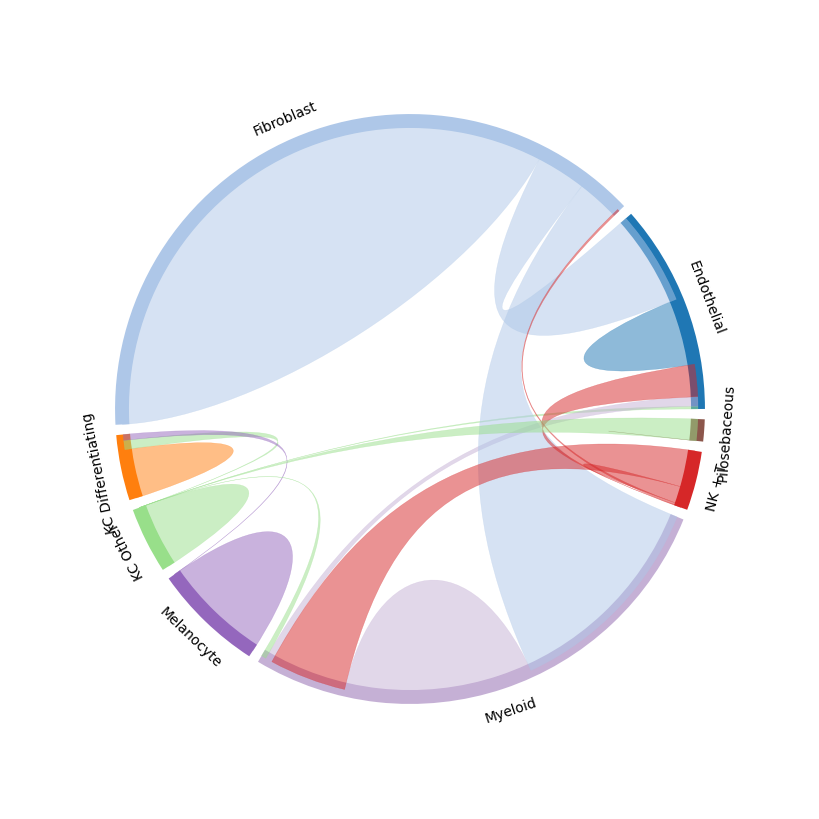

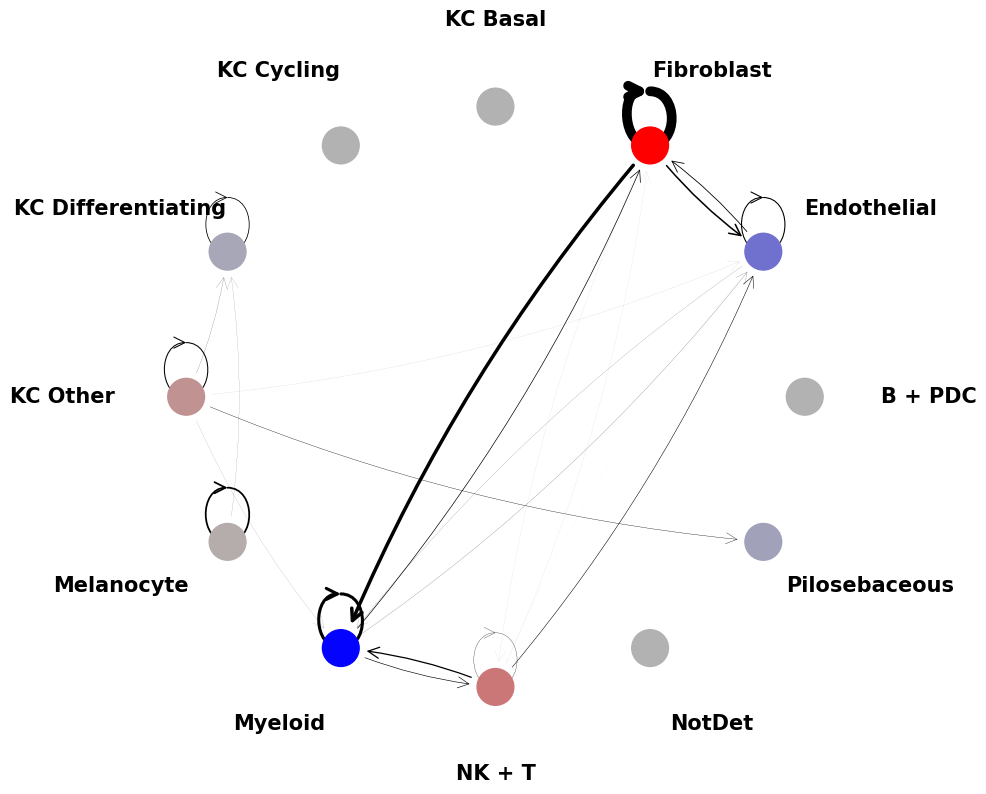

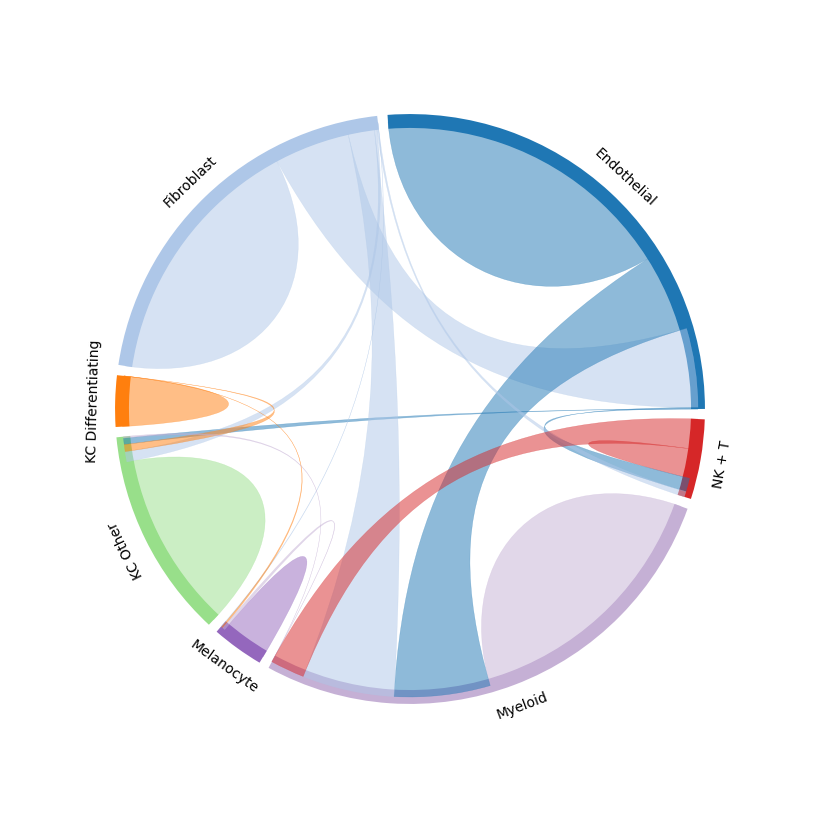

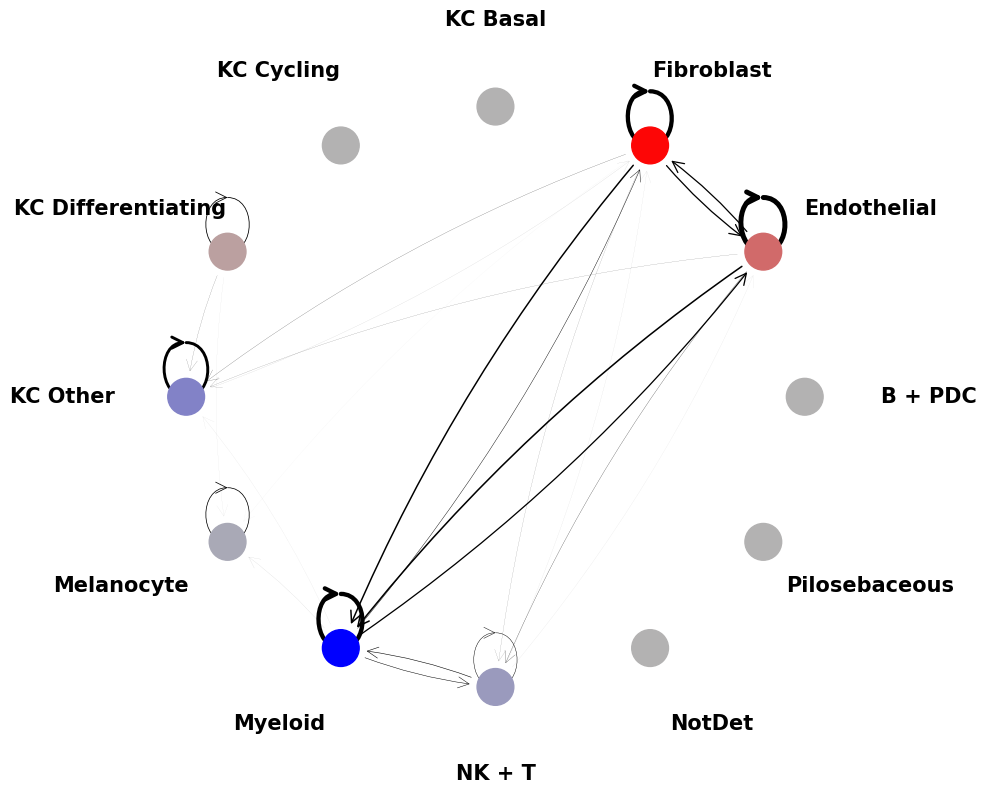

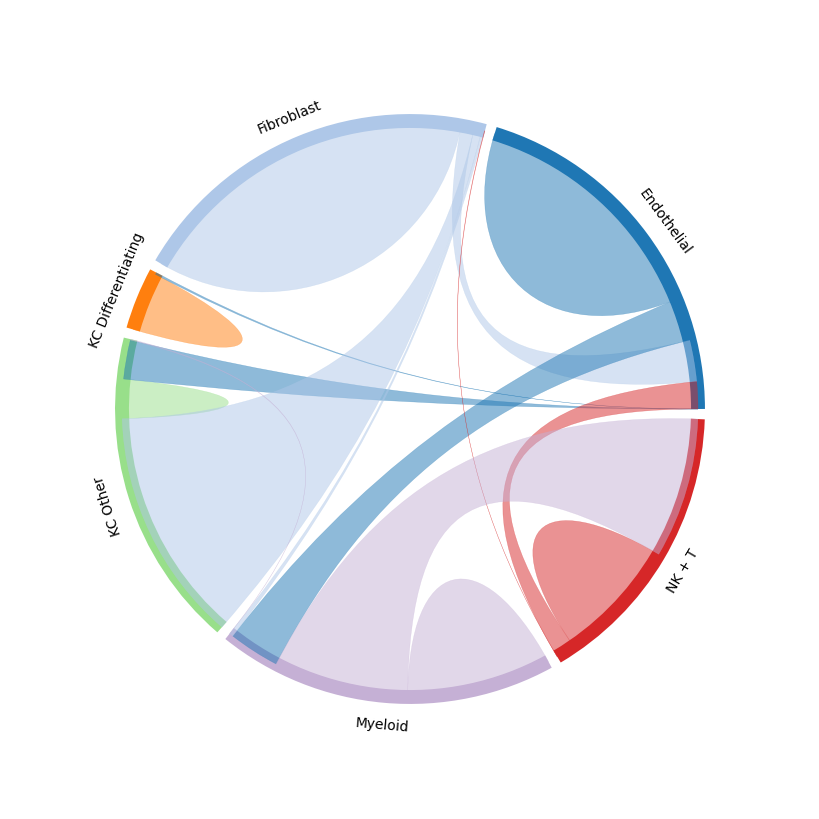

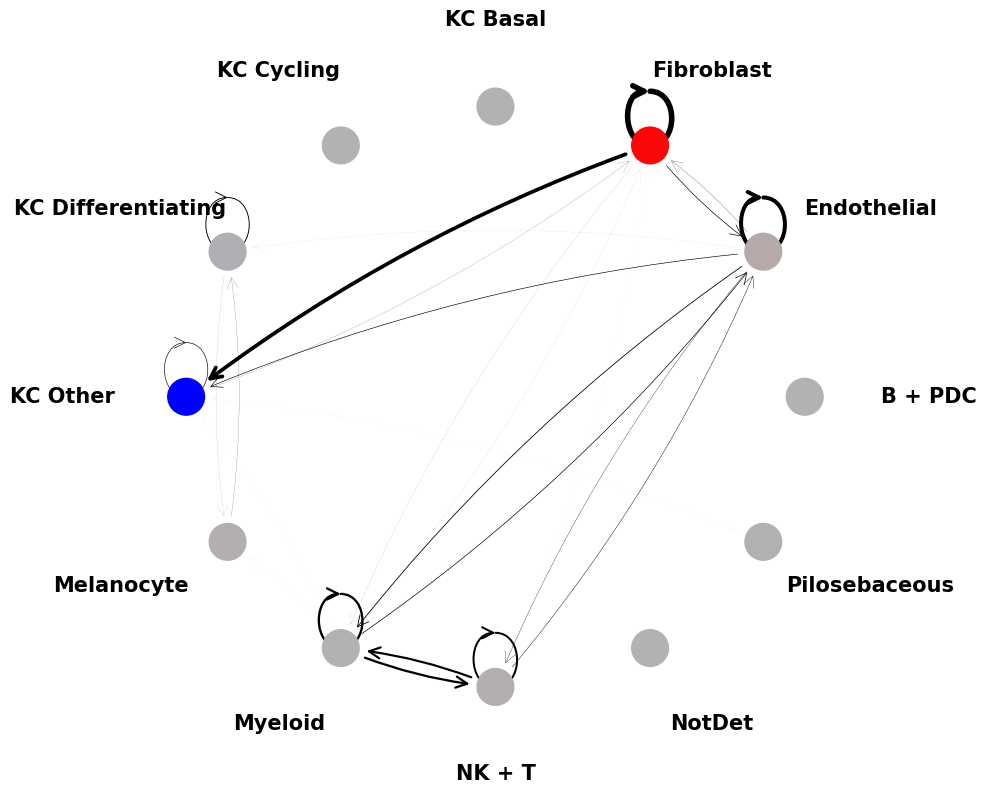

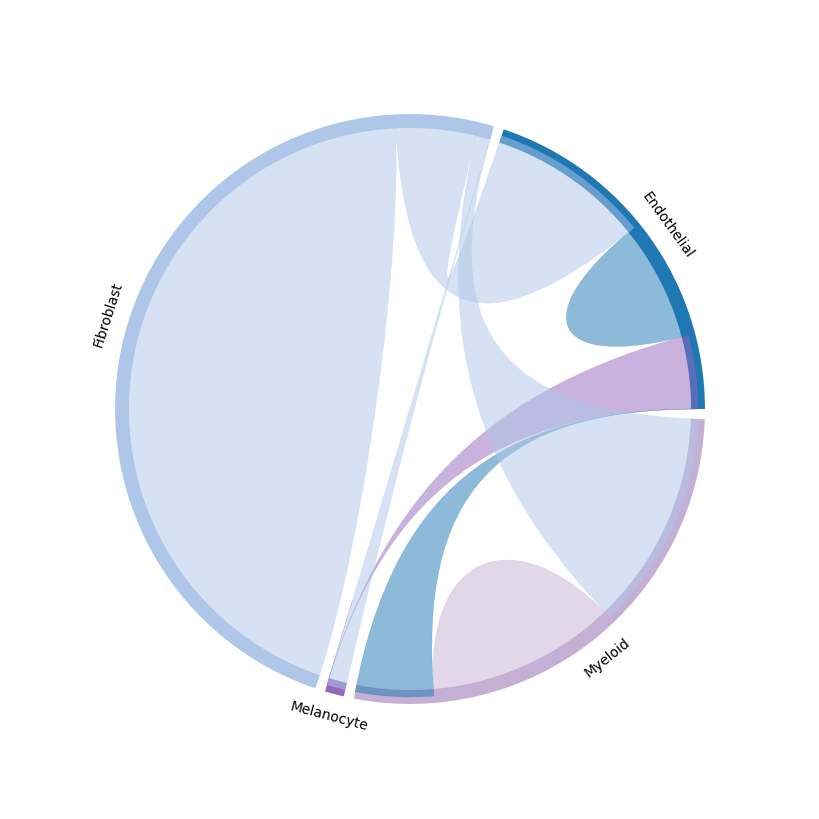

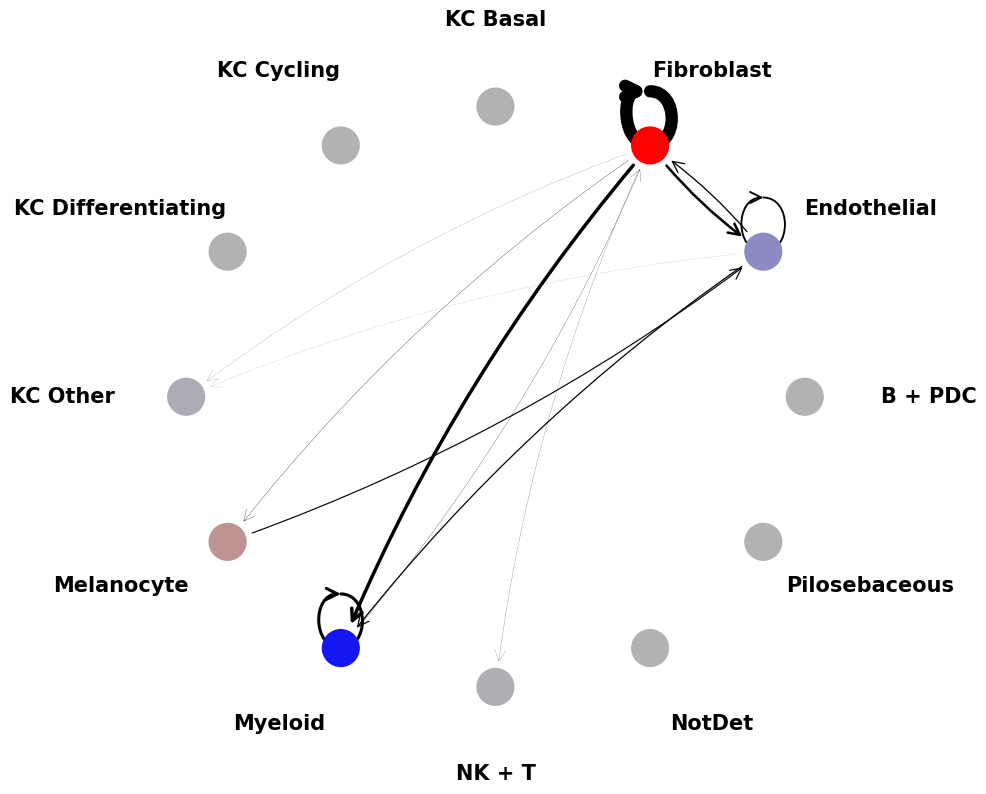

In [8]:
patient_integrated = {}

for patient, samples in patients.items():
    lr_pairs = mmcci.it.get_majority_lr_pairs(samples['vis'] + samples['cos'])
    visium_avg = mmcci.it.get_avg_lr_pairs(visium_normalised, lr_pairs)
    vis = mmcci.it.get_avg_lr_pairs(samples['vis'], lr_pairs)
    cos = mmcci.it.get_avg_lr_pairs(samples['cos'], lr_pairs)
    normalised = mmcci.it.normalise_samples_between_tech([[vis], [cos]])
    normalised = np.array(normalised).T.tolist()
    integrated = mmcci.it.integrate_between_tech(normalised[0])
    overall = mmcci.it.calculate_overall_interactions(integrated)
    mmcci.plt.chord_plot(overall, colors=colors)
    mmcci.plt.network_plot(overall)
    patient_integrated[patient] = integrated

#### Integrate Patients Together

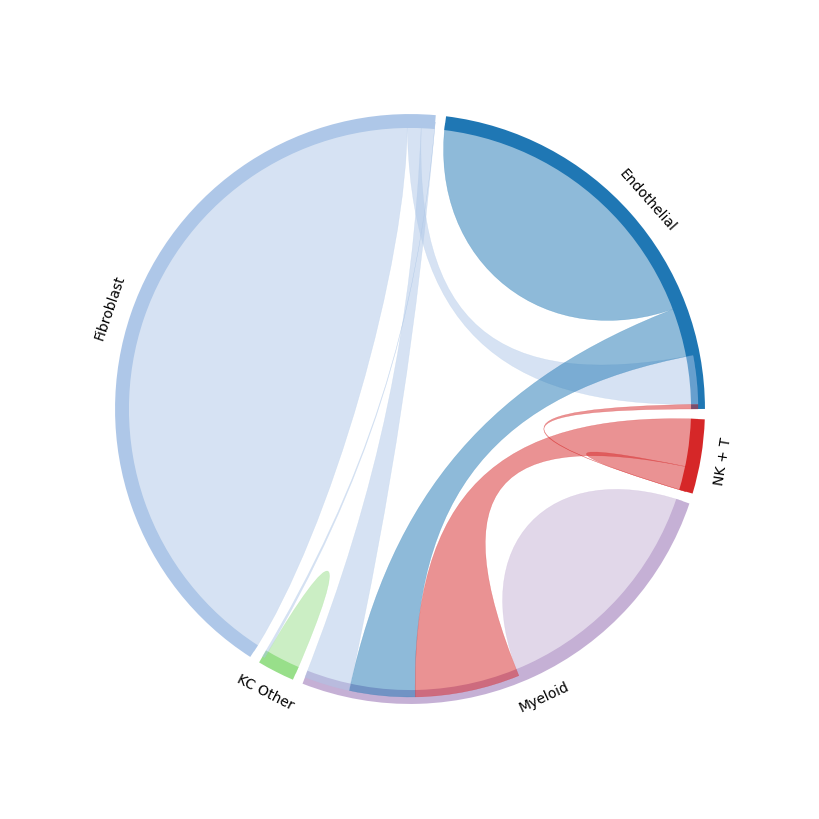

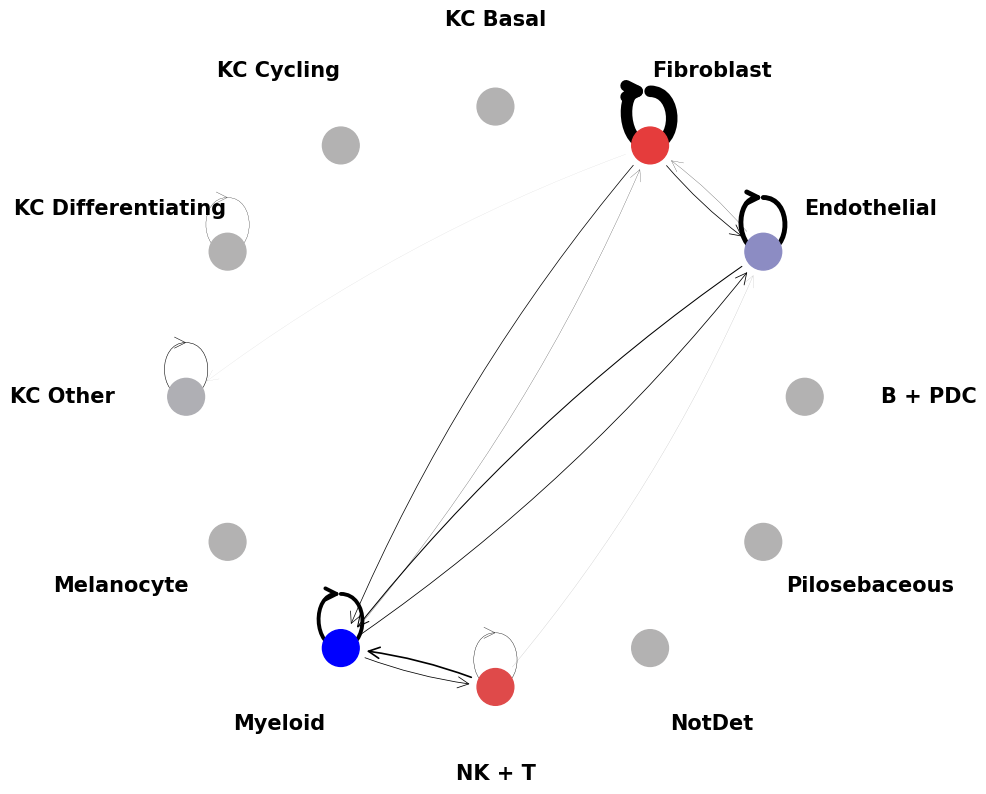

In [9]:
normalised = mmcci.it.normalise_samples_between_tech(
    [[patient_integrated['6747']], [patient_integrated['21031']], [patient_integrated['48974']], [patient_integrated['66487']]]
    )

normalised = np.array(normalised).T.tolist()
integrated = mmcci.it.integrate_between_tech(normalised[0])
overall = mmcci.it.calculate_overall_interactions(integrated)

mmcci.plt.chord_plot(overall, colors=colors)
mmcci.plt.network_plot(overall)

#### Integrate within tech

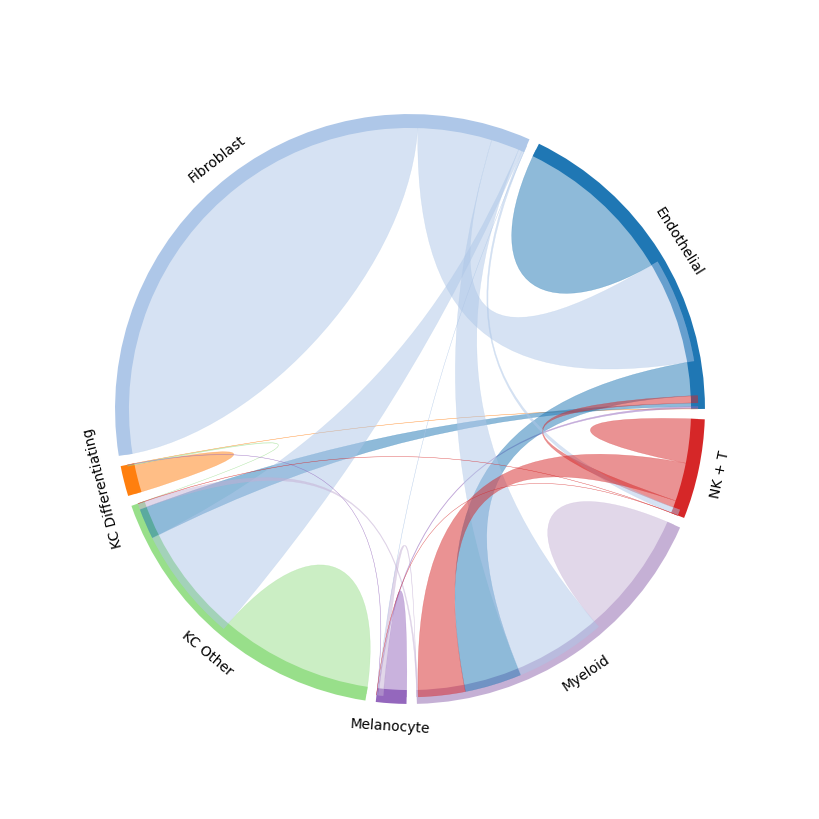

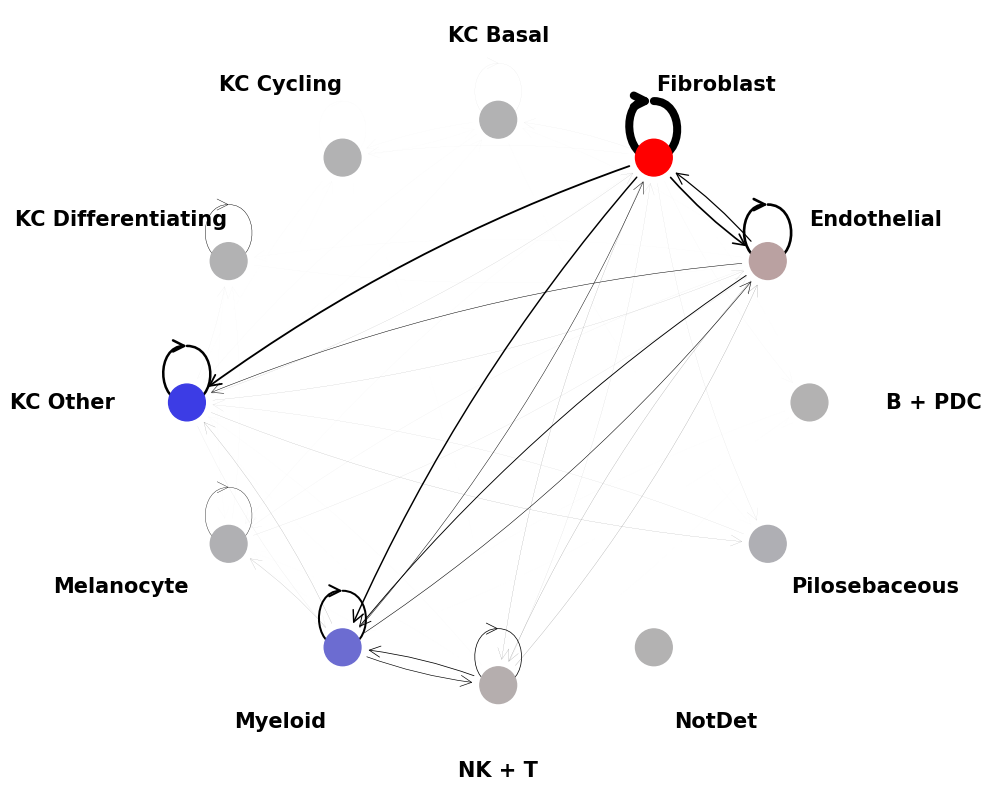

In [10]:
avg = {}
overall = {}

for tech, samples in zip(['vis', 'xen', 'cos'], [visium_normalised, xenium_normalised, cosmx_normalised]):
    lr_pairs = mmcci.it.get_majority_lr_pairs(samples)
    avg[tech] = mmcci.it.get_avg_lr_pairs(samples, lr_pairs)
    overall[tech] = mmcci.it.calculate_overall_interactions(avg[tech])
    # mmcci.plt.chord_plot(overall[tech], colors=colors)
    # mmcci.plt.network_plot(overall[tech])
    
normalised = mmcci.it.normalise_samples_between_tech(
    [[avg['vis']], [avg['xen']], [avg['cos']]]
    )

normalised = np.array(normalised).T.tolist()
integrated = mmcci.it.integrate_between_tech(normalised[0])
overall = mmcci.it.calculate_overall_interactions(integrated)

mmcci.plt.chord_plot(overall, colors=colors)
mmcci.plt.network_plot(overall)

In [11]:
print(len(avg['vis']))
print(len(avg['cos']))
print(len(avg['xen']))

487
517
12
